#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/AIVLE/AI_미니프로젝트 1차_실습자료/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩
    - pandas, numpy,matplotlib,seaborn, joblib 을 로딩하고
    필요한 라이브러리를 로딩합니다.
    <br>(분류 모델에서는 이번에 RandomForestClassifier를 씁니다. 더 많은 분류 모델을 써도 됩니다!)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns)
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [4]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [10]:
# 주어진 데이터 셋을 불러오세요.
import pandas as pd

# 데이터 불러오기
data01_train = pd.read_csv(path + 'data01_train.csv')
data01_test = pd.read_csv(path + 'data01_test.csv')

# 'subject' 칼럼 삭제
data01_train.drop(columns=['subject'], inplace=True)
data01_test.drop(columns=['subject'], inplace=True)

# 결과 확인
print(data01_train.head())
print(data01_test.head())

   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288508          -0.009196          -0.103362         -0.988986   
1           0.265757          -0.016576          -0.098163         -0.989551   
2           0.278709          -0.014511          -0.108717         -0.997720   
3           0.289795          -0.035536          -0.150354         -0.231727   
4           0.394807           0.034098           0.091229          0.088489   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.962797         -0.967422         -0.989000         -0.962596   
1         -0.994636         -0.987435         -0.990189         -0.993870   
2         -0.981088         -0.994008         -0.997934         -0.982187   
3         -0.006412         -0.338117         -0.273557          0.014245   
4         -0.106636         -0.388502         -0.010469         -0.109680   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyr

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [11]:
# 전체 데이터의 행, 열 개수를 확인

print("Train Data Shape:", data01_train.shape)
print("Test Data Shape:", data01_test.shape)


Train Data Shape: (5881, 562)
Test Data Shape: (1471, 562)


In [12]:
# 전체 데이터의 상위 5개 행 확인
print("\nTrain Data Head:")
print(data01_train.head())
print("\nTest Data Head:")
print(data01_test.head())



Train Data Head:
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288508          -0.009196          -0.103362         -0.988986   
1           0.265757          -0.016576          -0.098163         -0.989551   
2           0.278709          -0.014511          -0.108717         -0.997720   
3           0.289795          -0.035536          -0.150354         -0.231727   
4           0.394807           0.034098           0.091229          0.088489   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.962797         -0.967422         -0.989000         -0.962596   
1         -0.994636         -0.987435         -0.990189         -0.993870   
2         -0.981088         -0.994008         -0.997934         -0.982187   
3         -0.006412         -0.338117         -0.273557          0.014245   
4         -0.106636         -0.388502         -0.010469         -0.109680   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X 

In [13]:
# 전체 데이터의 수치형 변수 분포 확인
print("\nTrain Data Description:")
print(data01_train.describe())
print("\nTest Data Description:")
print(data01_test.describe())


Train Data Description:
       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count        5881.000000        5881.000000        5881.000000   
mean            0.274811          -0.017799          -0.109396   
std             0.067614           0.039422           0.058373   
min            -0.503823          -0.684893          -1.000000   
25%             0.262919          -0.024877          -0.121051   
50%             0.277154          -0.017221          -0.108781   
75%             0.288526          -0.010920          -0.098163   
max             1.000000           1.000000           1.000000   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count       5881.000000       5881.000000       5881.000000       5881.000000   
mean          -0.603138         -0.509815         -0.604058         -0.628151   
std            0.448807          0.501815          0.417319          0.424345   
min           -1.000000         -0.999844         -0.999

In [14]:
#전체 데이터의 모든 변수 확인
print("\nTrain Data Columns:")
print(data01_train.columns)
print("\nTest Data Columns:")
print(data01_test.columns)


Train Data Columns:
Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

Test Data Columns:
Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,

In [16]:
#(추가) 다양하게 기본 정보들을 확인하세요!
print("\nTrain Data Info:")
print(data01_train.info())
print("\nTest Data Info:")
print(data01_test.info())

# 결측치 개수 확인
print("\nMissing Values in Train Data:")
print(data01_train.isnull().sum())
print("\nMissing Values in Test Data:")
print(data01_test.isnull().sum())


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 6.3+ MB
None

Missing Values in Train Data:
tBodyAcc-mean()-X                       0
tBodyAcc-mean()-Y                       0
tBodyAcc-mean()-Z                       0
tBodyAcc-std()-X                        0
tBodyAcc-std()-Y                        0
                                       ..
angle(tBodyGyroJerkMean,gravityMean)    0
angle(X,gravityMean)                    0
angle(Y,gravityMean)                    0
angle(Z,gravityMean)                    0
Activity                                0
Length: 562, dtype: int64

Missing Values in Test Data:
tBodyAcc-mean()-X                       0
tBo

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [19]:
# Activity 에 대해서 단변량 분석을 시행합니다. (범주별 빈도수, 종류, 비율, 시각화도 해보기!)

#  'Activity' 컬럼의 범주 종류 확인
activity_categories = data01_train['Activity'].unique()
print("Unique Activity Categories:")
print(activity_categories)

# 'Activity' 컬럼의 범주별 빈도수 및 비율 계산
activity_counts = data01_train['Activity'].value_counts()
activity_proportions = data01_train['Activity'].value_counts(normalize=True)

#  빈도수와 비율을 하나의 데이터프레임으로 결합
activity_analysis = pd.DataFrame({
    'Frequency': activity_counts,
    'Proportion': activity_proportions
})
print("\nActivity Analysis:")
print(activity_analysis)

Unique Activity Categories:
['STANDING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS'
 'SITTING']

Activity Analysis:
                    Frequency  Proportion
Activity                                 
LAYING                   1115    0.189594
STANDING                 1087    0.184833
SITTING                  1032    0.175480
WALKING                   998    0.169699
WALKING_UPSTAIRS          858    0.145894
WALKING_DOWNSTAIRS        791    0.134501


<ipython-input-21-68a957ce1a89>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=activity_analysis.index, y=activity_analysis['Frequency'], palette='viridis')


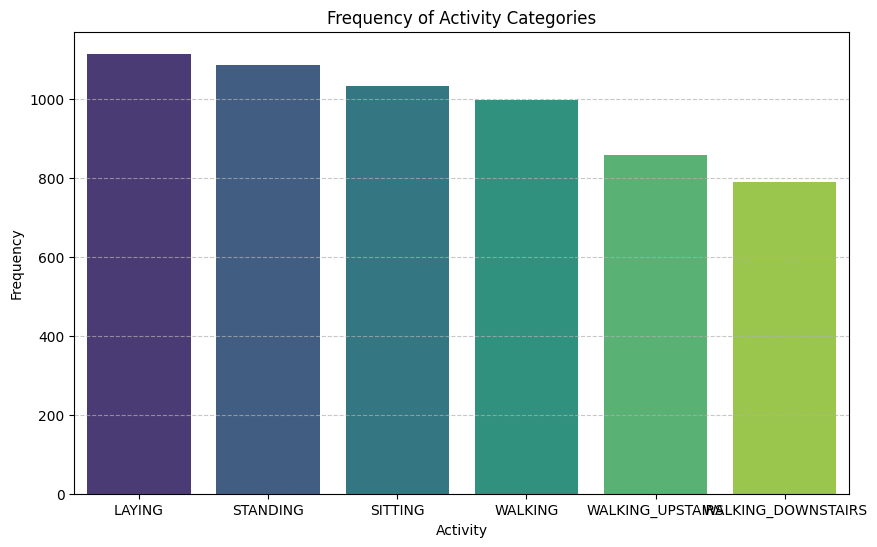

<ipython-input-21-68a957ce1a89>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=activity_analysis.index, y=activity_analysis['Proportion'], palette='pastel')


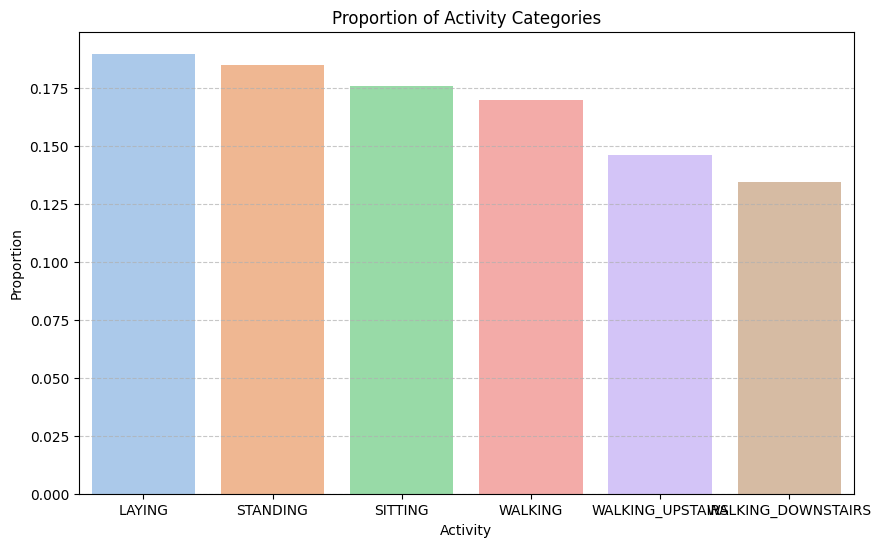

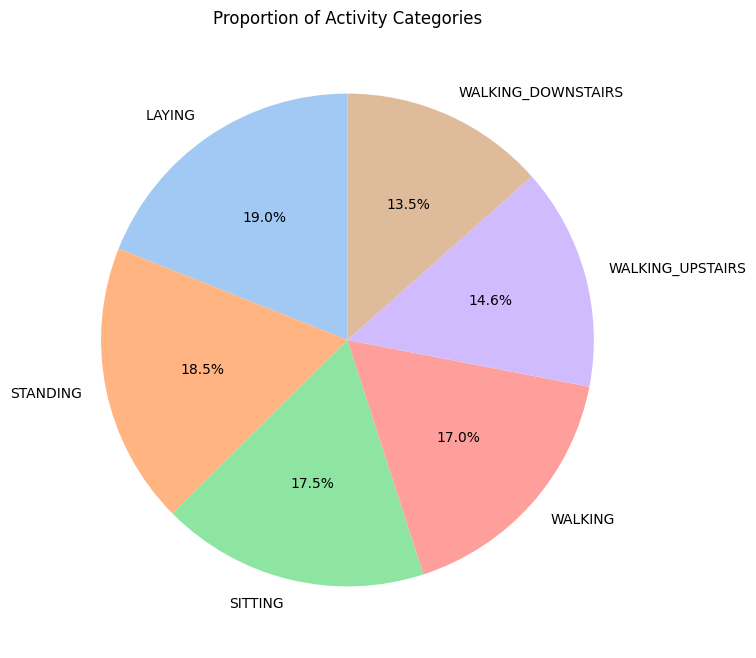

In [21]:
# 범주별 빈도수 및 비율 막대그래프
plt.figure(figsize=(10, 6))
sns.barplot(x=activity_analysis.index, y=activity_analysis['Frequency'], palette='viridis')
plt.title('Frequency of Activity Categories')
plt.xlabel('Activity')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=activity_analysis.index, y=activity_analysis['Proportion'], palette='pastel')
plt.title('Proportion of Activity Categories')
plt.xlabel('Activity')
plt.ylabel('Proportion')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 범주별 비율 파이차트
plt.figure(figsize=(8, 8))
activity_proportions.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Proportion of Activity Categories')
plt.ylabel('')  # 파이차트에서 y축 레이블 제거
plt.show()

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [24]:
#센서 그룹 데이터의 'sensor'변수의 값 확인

# 센서 그룹 데이터 불러오기
try:
    features = pd.read_csv(path + 'features.csv')
    print("Data Loaded Successfully!")
except FileNotFoundError:
    print("File not found. Please check the file path and try again.")

#  'sensor' 변수의 값 확인 및 개수 카운트
if 'sensor' in features.columns:
    sensor_counts = features['sensor'].value_counts()
    print("\nSensor Variable Counts:")
    print(sensor_counts)

Data Loaded Successfully!

Sensor Variable Counts:
sensor
fBodyGyro               79
fBodyAccJerk            79
fBodyAcc                79
tBodyAcc                40
tGravityAcc             40
tBodyAccJerk            40
tBodyGyroJerk           40
tBodyGyro               40
tGravityAccMag          13
tBodyAccMag             13
tBodyGyroJerkMag        13
tBodyGyroMag            13
tBodyAccJerkMag         13
fBodyAccMag             13
fBodyBodyAccJerkMag     13
fBodyBodyGyroMag        13
fBodyBodyGyroJerkMag    13
angle                    7
Name: count, dtype: int64


In [26]:
#센서 그룹 데이터의 'agg'변수의 값 확인

if 'agg' in features.columns:
    agg_counts = features['agg'].value_counts()
    print("\nAggregation (agg) Variable Counts:")
    print(agg_counts)


Aggregation (agg) Variable Counts:
agg
bandsEnergy()        126
arCoeff()             60
std()                 33
mad()                 33
max()                 33
energy()              33
min()                 33
entropy()             33
iqr()                 33
mean()                33
sma()                 17
correlation()         15
kurtosis()            13
meanFreq()            13
skewness()            13
maxInds               13
arCoeff()4             5
arCoeff()2             5
arCoeff()3             5
arCoeff()1             5
tBodyAccMean           1
tBodyAccJerkMean       1
tBodyGyroMean          1
tBodyGyroJerkMean      1
X                      1
Y                      1
Z                      1
Name: count, dtype: int64


In [27]:
#센서 그룹 데이터의 'axis'변수의 값 확인

# (3) 'axis' 변수의 값 확인 및 개수 카운트
if 'axis' in features.columns:
    axis_counts = features['axis'].value_counts()
    print("\nAxis Variable Counts:")
    print(axis_counts)

# (4) 추가 정보 확인 - 데이터 미리보기
print("\nFeatures Data Preview:")
print(features.head())


Axis Variable Counts:
axis
X              76
Y              76
Z              76
gravityMean     6
X,2             5
               ..
17,32.2         2
49,64.2         2
1,24.2          2
25,48.2         2
gravity         1
Name: count, Length: 62, dtype: int64

Features Data Preview:
     sensor     agg axis       feature_name
0  tBodyAcc  mean()    X  tBodyAcc-mean()-X
1  tBodyAcc  mean()    Y  tBodyAcc-mean()-Y
2  tBodyAcc  mean()    Z  tBodyAcc-mean()-Z
3  tBodyAcc   std()    X   tBodyAcc-std()-X
4  tBodyAcc   std()    Y   tBodyAcc-std()-Y


## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [28]:
# 데이터 분할을 위한 전처리
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

# 파일 경로 설정
path = '/content/drive/MyDrive/AIVLE/AI_미니프로젝트 1차_실습자료/'

# 데이터 불러오기
data01_train = pd.read_csv(path + 'data01_train.csv')

# 'subject' 칼럼 삭제
data01_train.drop(columns=['subject'], inplace=True)

# X (features)와 y (target) 분리
X = data01_train.drop(columns=['Activity'])
y = data01_train['Activity']

# Train-validation 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 분할 결과 확인
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shape: (4704, 561)
Validation shape: (1177, 561)


#### 2) 모델링

In [29]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 랜덤포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# 변수 중요도 추출
feature_importances = rf_model.feature_importances_
feature_names = X.columns

# 사용자 정의 함수: plot_feature_importance
def plot_feature_importance(importance, names, result_only=False, topn='all'):
    feature_importance = pd.DataFrame({
        'feature_name': names,
        'feature_importance': importance
    }).sort_values(by='feature_importance', ascending=False)

    if topn != 'all':
        feature_importance = feature_importance.head(topn)

    if not result_only:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='feature_importance', y='feature_name', data=feature_importance)
        plt.title('Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Feature Name')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.show()

    return feature_importance

#### 3) 변수 중요도 추출

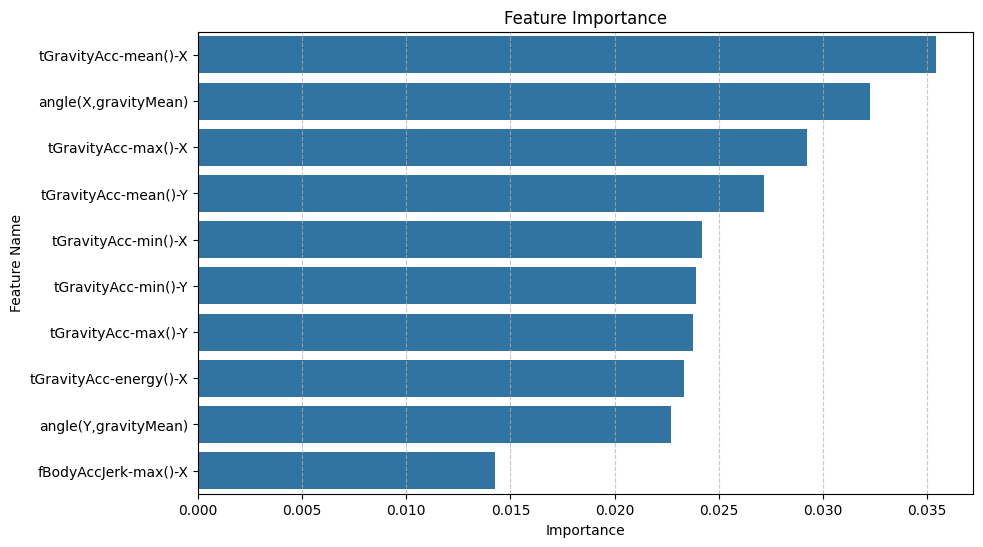

Top 10 Important Features:
               feature_name  feature_importance
40     tGravityAcc-mean()-X            0.035434
558    angle(X,gravityMean)            0.032244
49      tGravityAcc-max()-X            0.029213
41     tGravityAcc-mean()-Y            0.027175
52      tGravityAcc-min()-X            0.024205
53      tGravityAcc-min()-Y            0.023930
50      tGravityAcc-max()-Y            0.023751
56   tGravityAcc-energy()-X            0.023343
559    angle(Y,gravityMean)            0.022725
353    fBodyAccJerk-max()-X            0.014275


In [30]:
# 변수 중요도 추출(시각화로 나타내기)

important_features = plot_feature_importance(feature_importances, feature_names, topn=10)
print("Top 10 Important Features:")
print(important_features)

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [31]:
# 중요도 상위 top 5

top_5_features = important_features.head(5)['feature_name'].tolist()
print("Top 5 Features:", top_5_features)

Top 5 Features: ['tGravityAcc-mean()-X', 'angle(X,gravityMean)', 'tGravityAcc-max()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-min()-X']


In [32]:
# 중요도 하위 top 5

bottom_5_features = important_features.tail(5)['feature_name'].tolist()
print("Bottom 5 Features:", bottom_5_features)

Bottom 5 Features: ['tGravityAcc-min()-Y', 'tGravityAcc-max()-Y', 'tGravityAcc-energy()-X', 'angle(Y,gravityMean)', 'fBodyAccJerk-max()-X']


#### 2) 상위 5개 변수에 대한 분석
        - 위에서 나온 상위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

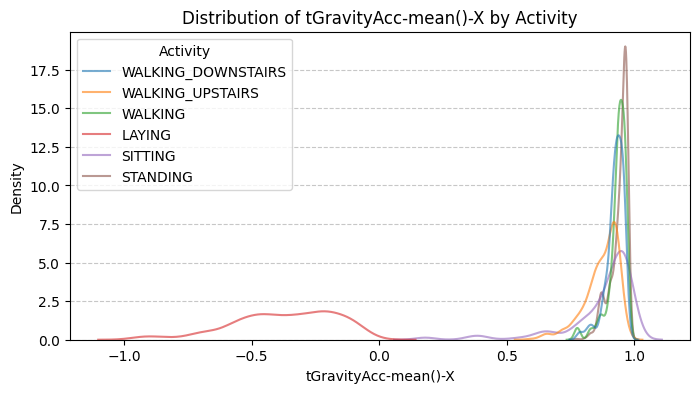

In [40]:
#1위 : tGravityAcc-mean()-X
import matplotlib.pyplot as plt
import seaborn as sns

# 상위 5개 변수 선정
top_5_features = important_features.head(5)['feature_name'].tolist()

# (1) 첫 번째 변수 시각화
plt.figure(figsize=(8, 4))
sns.kdeplot(data=X_train, x=X_train[top_5_features[0]], hue=y_train,  common_norm=False, alpha=0.6)
plt.title(f"Distribution of {top_5_features[0]} by Activity")
plt.xlabel(top_5_features[0])
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

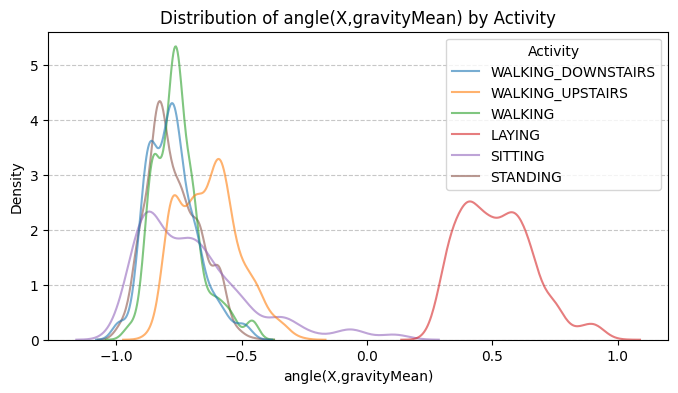

In [41]:
#2위: angle(X,gravityMean)

plt.figure(figsize=(8, 4))
sns.kdeplot(data=X_train, x=X_train[top_5_features[1]], hue=y_train, common_norm=False, alpha=0.6)
plt.title(f"Distribution of {top_5_features[1]} by Activity")
plt.xlabel(top_5_features[1])
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

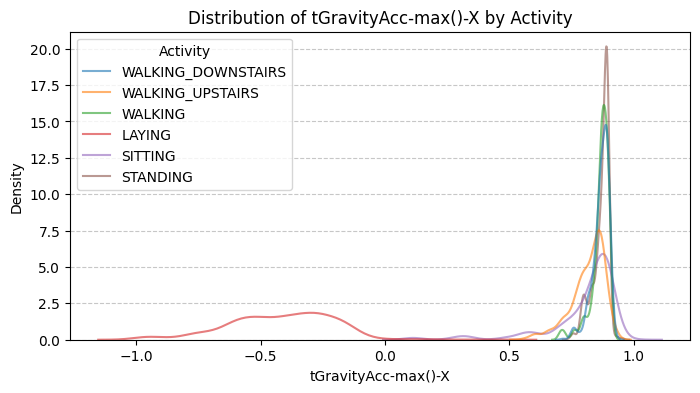

In [42]:
#3위: tGravityAcc-max()-X
plt.figure(figsize=(8, 4))
sns.kdeplot(data=X_train, x=X_train[top_5_features[2]], hue=y_train,  common_norm=False, alpha=0.6)
plt.title(f"Distribution of {top_5_features[2]} by Activity")
plt.xlabel(top_5_features[2])
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

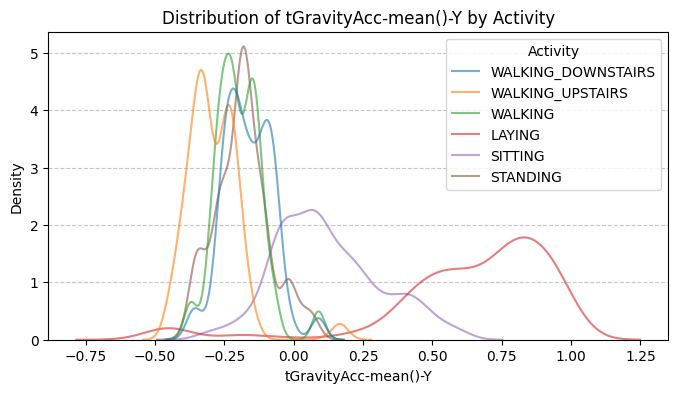

In [43]:
#4위: tGravityAcc-mean()-Y
plt.figure(figsize=(8, 4))
sns.kdeplot(data=X_train, x=X_train[top_5_features[3]], hue=y_train,  common_norm=False, alpha=0.6)
plt.title(f"Distribution of {top_5_features[3]} by Activity")
plt.xlabel(top_5_features[3])
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



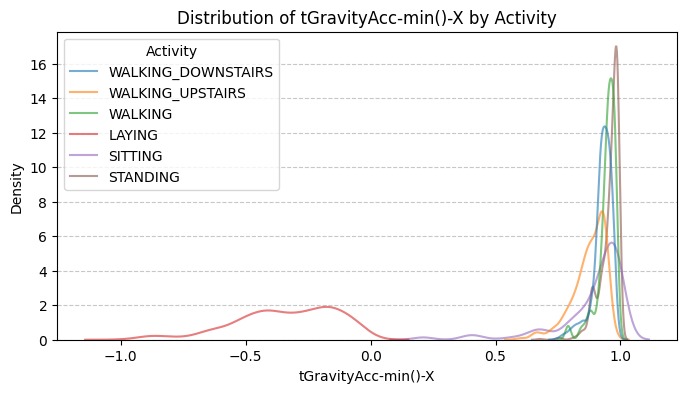

In [44]:
#5위: tGravityAcc-min()-X
plt.figure(figsize=(8, 4))
sns.kdeplot(data=X_train, x=X_train[top_5_features[4]], hue=y_train, common_norm=False, alpha=0.6)
plt.title(f"Distribution of {top_5_features[4]} by Activity")
plt.xlabel(top_5_features[4])
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 3) 하위 5개 변수에 대한 분석
        - 위에서 하위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

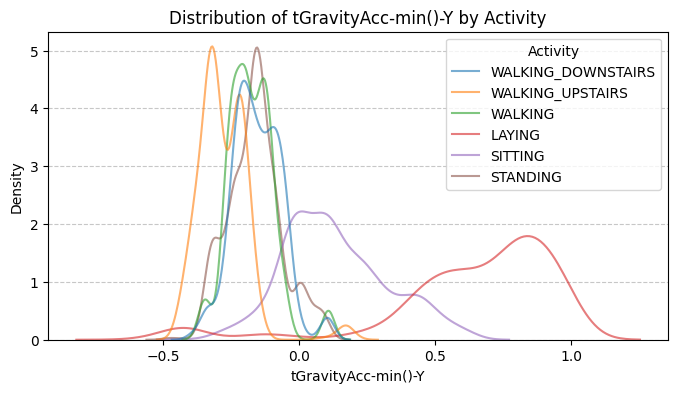

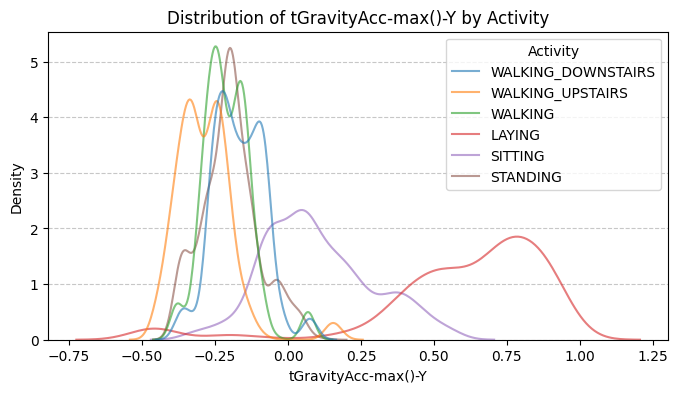

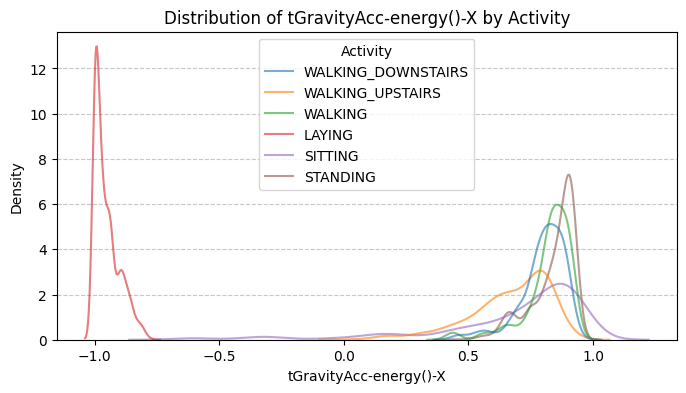

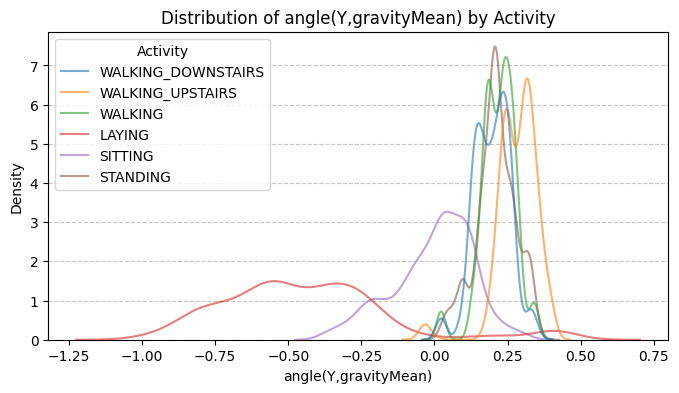

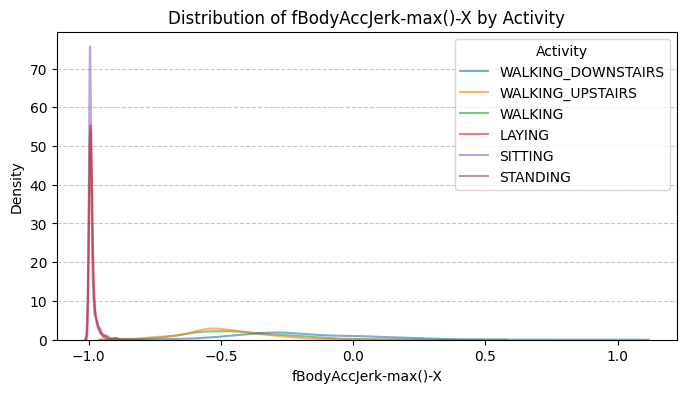

In [47]:

# 하위 5개 변수 선정
bottom_5_features = important_features.tail(5)['feature_name'].tolist()

# 1위 하위 변수 시각화
plt.figure(figsize=(8, 4))
sns.kdeplot(data=X_train, x=X_train[bottom_5_features[0]], hue=y_train,  common_norm=False, alpha=0.6)
plt.title(f"Distribution of {bottom_5_features[0]} by Activity")
plt.xlabel(bottom_5_features[0])
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#  2위 하위 변수 시각화
plt.figure(figsize=(8, 4))
sns.kdeplot(data=X_train, x=X_train[bottom_5_features[1]], hue=y_train,  common_norm=False, alpha=0.6)
plt.title(f"Distribution of {bottom_5_features[1]} by Activity")
plt.xlabel(bottom_5_features[1])
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#  3위 하위 변수 시각화
plt.figure(figsize=(8, 4))
sns.kdeplot(data=X_train, x=X_train[bottom_5_features[2]], hue=y_train,  common_norm=False, alpha=0.6)
plt.title(f"Distribution of {bottom_5_features[2]} by Activity")
plt.xlabel(bottom_5_features[2])
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4위 하위 변수 시각화
plt.figure(figsize=(8, 4))
sns.kdeplot(data=X_train, x=X_train[bottom_5_features[3]], hue=y_train,  common_norm=False, alpha=0.6)
plt.title(f"Distribution of {bottom_5_features[3]} by Activity")
plt.xlabel(bottom_5_features[3])
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 5위 하위 변수 시각화
plt.figure(figsize=(8, 4))
sns.kdeplot(data=X_train, x=X_train[bottom_5_features[4]], hue=y_train,  common_norm=False, alpha=0.6)
plt.title(f"Distribution of {bottom_5_features[4]} by Activity")
plt.xlabel(bottom_5_features[4])
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.


#### 1) is_dynamic 추가

In [63]:
unique_activities = data01_train['Activity'].unique()
print("Unique Activities:", unique_activities)

Unique Activities: ['STANDING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS'
 'SITTING']


In [65]:
# Activity 값별 행 개수 확인
activity_counts = data01_train['Activity'].value_counts()
print(activity_counts)


Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64


In [75]:
#is dynamic 변수를 추가하세요(값 0, 값 1 확인해서!)

# Activity 컬럼 정리 (공백 제거 및 대문자로 변환)
data01_train['Activity'] = data01_train['Activity'].str.strip().str.upper()

# is_dynamic 변수 생성
static_actions = ['STANDING', 'SITTING', 'LAYING']
dynamic_actions = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
data01_train['is_dynamic'] = data01_train['Activity'].apply(lambda x: 1 if x in dynamic_actions else 0)

# 결과 확인
print(data01_train[['Activity', 'is_dynamic']].head(10))


             Activity  is_dynamic
0            STANDING           0
1              LAYING           0
2            STANDING           0
3             WALKING           1
4  WALKING_DOWNSTAIRS           1
5    WALKING_UPSTAIRS           1
6             WALKING           1
7            STANDING           0
8            STANDING           0
9            STANDING           0


#### 2) 기본모델 생성

In [50]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# X (features)와 y (target) 분리
X = data01_train.drop(columns=['Activity', 'is_dynamic'])
y = data01_train['is_dynamic']

# Train-validation 분할 (train:val = 8:2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# 검증 데이터로 평가
y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

Validation Accuracy: 1.00


#### 3) 변수중요도 상위 5개 분석

In [52]:
# is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석!

# 변수 중요도 추출
feature_importances = rf_model.feature_importances_
feature_names = X.columns

# 중요도 데이터프레임 생성 및 정렬
important_features = pd.DataFrame({
    'feature_name': feature_names,
    'feature_importance': feature_importances
}).sort_values(by='feature_importance', ascending=False)

# 상위 5개 변수 선정
top_5_features = important_features.head(5)['feature_name'].tolist()
print("Top 5 Important Features for is_dynamic:")
print(top_5_features)

Top 5 Important Features for is_dynamic:
['tBodyGyroJerk-iqr()-Z', 'fBodyAccJerk-max()-X', 'fBodyAccJerk-bandsEnergy()-1,16', 'tBodyAccJerk-std()-X', 'tBodyAccJerk-iqr()-X']


* 미션1에서 했던 것 처럼 상위 5개의 변수 데이터를 탐색해보기!

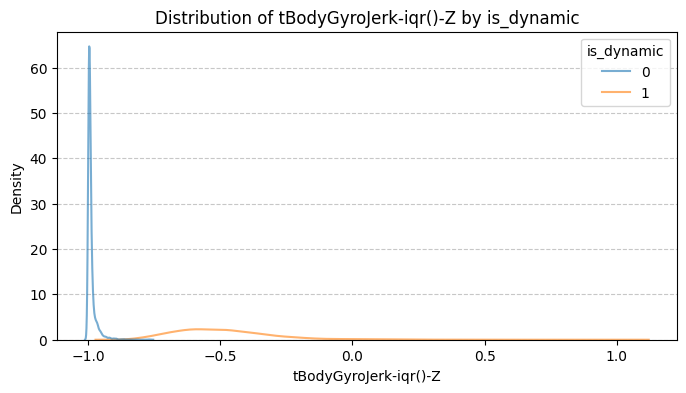

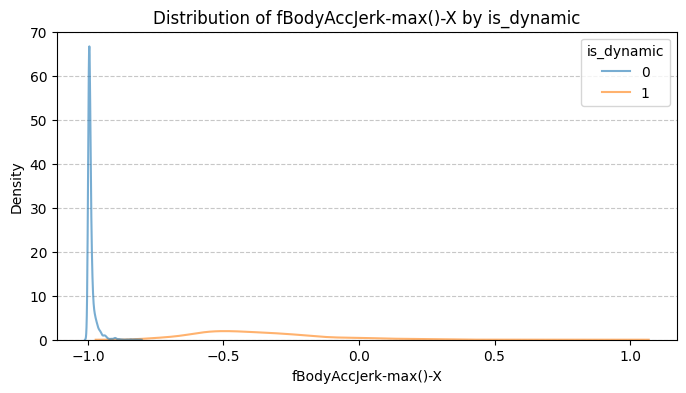

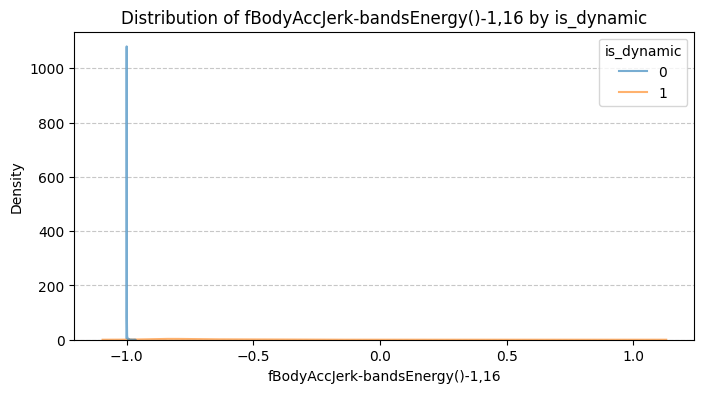

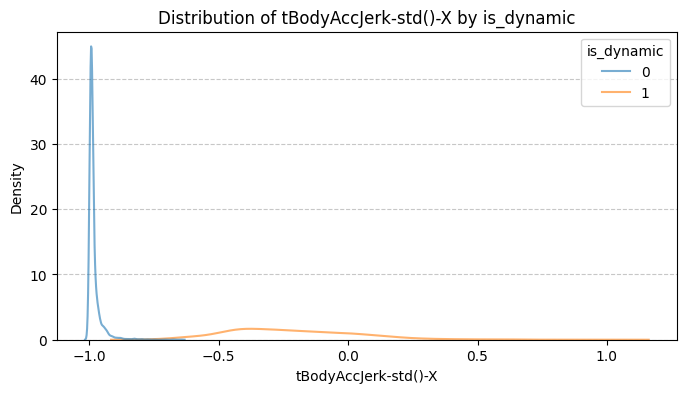

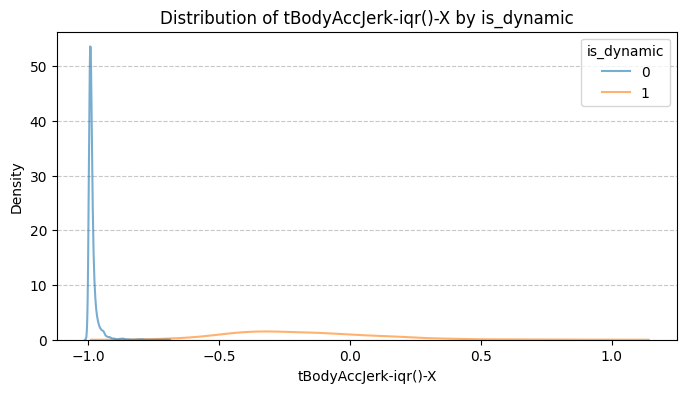

In [54]:
# 첫 번째 변수 시각화 (상위 1위)
plt.figure(figsize=(8, 4))
sns.kdeplot(data=X_train, x=X_train[top_5_features[0]], hue=y_train, common_norm=False, alpha=0.6)
plt.title(f"Distribution of {top_5_features[0]} by is_dynamic")
plt.xlabel(top_5_features[0])
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 두 번째 변수 시각화 (상위 2위)
plt.figure(figsize=(8, 4))
sns.kdeplot(data=X_train, x=X_train[top_5_features[1]], hue=y_train,  common_norm=False, alpha=0.6)
plt.title(f"Distribution of {top_5_features[1]} by is_dynamic")
plt.xlabel(top_5_features[1])
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 세 번째 변수 시각화 (상위 3위)
plt.figure(figsize=(8, 4))
sns.kdeplot(data=X_train, x=X_train[top_5_features[2]], hue=y_train, common_norm=False, alpha=0.6)
plt.title(f"Distribution of {top_5_features[2]} by is_dynamic")
plt.xlabel(top_5_features[2])
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 네 번째 변수 시각화 (상위 4위)
plt.figure(figsize=(8, 4))
sns.kdeplot(data=X_train, x=X_train[top_5_features[3]], hue=y_train, common_norm=False, alpha=0.6)
plt.title(f"Distribution of {top_5_features[3]} by is_dynamic")
plt.xlabel(top_5_features[3])
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 다섯 번째 변수 시각화 (상위 5위)
plt.figure(figsize=(8, 4))
sns.kdeplot(data=X_train, x=X_train[top_5_features[4]], hue=y_train,  common_norm=False, alpha=0.6)
plt.title(f"Distribution of {top_5_features[4]} by is_dynamic")
plt.xlabel(top_5_features[4])
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

#### 1) 이름변경

In [76]:
# tip : rename을 써서 칼럼 이름 수정을 해야합니다!

importance_6_actions = pd.DataFrame({
    'feature_name': ['feature1', 'feature2', 'feature3'],
    'feature_importance': [0.3, 0.5, 0.2]
})

importance_dynamic_static = pd.DataFrame({
    'feature_name': ['feature1', 'feature2', 'feature3'],
    'feature_importance': [0.4, 0.4, 0.2]
})

# feature_importance 열 이름 변경 (구분하기 쉽게)
importance_6_actions.rename(columns={'feature_importance': 'importance_6_actions'}, inplace=True)
importance_dynamic_static.rename(columns={'feature_importance': 'importance_dynamic_static'}, inplace=True)

print("열 이름이 변경된 데이터프레임:")
print(importance_6_actions.head())
print(importance_dynamic_static.head())

열 이름이 변경된 데이터프레임:
  feature_name  importance_6_actions
0     feature1                   0.3
1     feature2                   0.5
2     feature3                   0.2
  feature_name  importance_dynamic_static
0     feature1                        0.4
1     feature2                        0.4
2     feature3                        0.2


#### 2) 합치기

In [77]:
# merge 해서 2개를 합치는 작업하기

# 두 변수 중요도 데이터프레임 병합
merged_importance = pd.merge(importance_6_actions, importance_dynamic_static, on='feature_name', how='outer')

print("병합된 변수 중요도 데이터프레임:")
print(merged_importance.head())

병합된 변수 중요도 데이터프레임:
  feature_name  importance_6_actions  importance_dynamic_static
0     feature1                   0.3                        0.4
1     feature2                   0.5                        0.4
2     feature3                   0.2                        0.2


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [78]:
# joblib.dump 이용해서 colab에 .pkl 파일에 저장하기(tip: path + '파일 이름.pkl')

import joblib

# 병합된 데이터프레임을 .pkl 파일로 저장
path = '/content/drive/MyDrive/AIVLE/AI_미니프로젝트 1차_실습자료/'
file_name = 'merged_importance.pkl'

try:
    joblib.dump(merged_importance, path + file_name)
    print(f"병합된 변수 중요도 데이터프레임이 {path + file_name}로 저장되었습니다.")
except FileNotFoundError:
    print("FileNotFoundError: 디렉토리가 존재하지 않거나 경로가 잘못 지정되었습니다. 경로를 확인하세요.")

병합된 변수 중요도 데이터프레임이 /content/drive/MyDrive/AIVLE/AI_미니프로젝트 1차_실습자료/merged_importance.pkl로 저장되었습니다.


#### 고생하셨습니다! 이제 기본 모델링을 해봅시다.